# Notebook to plot output from SEDNA, a 1/60° pan-Arctic resolution simulation. 

Import and start dask client. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
import colorcet as ccet
import xrft
import matplotlib.colors as colors
import matplotlib.ticker as ticker

In [2]:
from dask.distributed import Client
import dask
import os
import datetime

client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46526,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:48267,Total threads: 1
Dashboard: http://127.0.0.1:46551/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:46501,


In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.path as mpath
# Replace path of cartopy shapefiles
cartopy.config['pre_existing_data_dir']='/home1/datahome/jmartine/.local/share/cartopy/shapefiles/natural_earth/'

## Import the data from disk.

In [4]:
out_path = "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/IMMEDIAT/CONFIGS/SEDNA/DELTA/2014/1d/*/"

In [5]:
ice_ds = xr.open_mfdataset(out_path+'/*icemod*.nc',parallel=True,decode_coords=False).chunk(chunks={'time_counter':5,'x':800,'y':500})

In [6]:
temp_ds = xr.open_mfdataset(out_path+'/*1d_gridT.nc',parallel=True,decode_coords=False).isel(deptht=1).chunk(chunks={'time_counter':5,'x':800,'y':500})

In [7]:
salt_ds = xr.open_mfdataset(out_path+'/*1d_gridS.nc',parallel=True,decode_coords=False).isel(deptht=1).chunk(chunks={'time_counter':5,'x':800,'y':500})

Import model grid and replace the coordinates in the ice dataset for the countour plots.

In [8]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/IMMEDIAT/CONFIGS/SEDNA/GRID/SEDNA_Domain_cfg_Tgt_20210820_tsh10m_L1.nc')

In [9]:
ice_ds = ice_ds.assign_coords({'nav_lon':grid.nav_lon % 360,'nav_lat':grid.nav_lat})

Extract variables from datasets

In [10]:
temp = temp_ds.votemper
salt = salt_ds.vosaline

In [11]:
ice_conc = ice_ds.sivolu

Extract the day 2nd of November 2014

In [12]:
area_of_interest_ts = {'time_counter': 315}

iceplot = ice_conc.where(ice_conc.nav_lon!=-1).isel(area_of_interest_ts).load()

saltplot = salt.where(ice_ds.nav_lon!=-1).isel(area_of_interest_ts).load()
tempplot = temp.where(ice_ds.nav_lon!=-1).isel(area_of_interest_ts).load()

Select data and coordenates to define the zoomed area within the Laptev Sea.

In [13]:
y0=4500
y1=5000
x0=4000
x1=4500

area_of_interest = {'time_counter': slice(285+10,285+30,10) ,'y':slice(y0,y1),'x':slice(x0,x1)}

In [14]:
iceplot_sdom = ice_conc.where(ice_conc.nav_lon!=-1).isel(area_of_interest).load()
saltplot_sdom = salt.where(ice_ds.nav_lon!=-1).isel(area_of_interest).load()
tempplot_sdom = temp.where(ice_ds.nav_lon!=-1).isel(area_of_interest).load()

In [15]:
nav_lon = ice_conc.nav_lon.isel({'y':slice(y0,y1),'x':slice(x0,x1)})
nav_lat = ice_conc.nav_lat.isel({'y':slice(y0,y1),'x':slice(x0,x1)})

Functions to simplify the plotting process

In [16]:
import cartopy.crs as ccrs
import numpy as np


def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3, angle=0, color='k'):
    """
    ---
    This function creates a scalebar in kilometers within the maps.
    ---
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.NorthPolarStereo(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = (x0 + (x1 - x0) * location[0] )
    sby = (y0 + (y1 - y0) * location[1] )
    
    X0 = sbx - (length/2) * 1000
    Y0 = sby

    X1 = X0 - (length*1000)*np.cos(np.radians(angle))
    Y1 = Y0 - (length*1000)*np.sin(np.radians(angle))
    
    X1_2 = X0 - ((length/2)*1000)*np.cos(np.radians(angle))
    Y1_2 = Y0 - ((length/2)*1000)*np.sin(np.radians(angle))
    
    x = np.array([X0,X1])
    y = np.array([Y0,Y1])
    
    #Generate the x coordinate for the ends of the scalebar
    xl1 = np.array([X0,X1_2])
    yl1 = np.array([Y0,Y1_2])
    xl2 = np.array([X1_2,X1])
    yl2 = np.array([Y1_2,Y1])

    ax.plot(x, y, transform=tmc, color='w', linewidth=linewidth+0.5)
    ax.plot(xl1, yl1, transform=tmc, color='k', linewidth=linewidth)
    ax.plot(xl2, yl2, transform=tmc, color='w', linewidth=linewidth)

    #Plot the scalebar label
    ax.text(X1, Y1 + 5000, '' + str(0), transform=tmc, #rotation = -0.55*angle,
            horizontalalignment='center', verticalalignment='bottom',color=color,fontsize=5)
    ax.text(X1_2, Y1_2 + 5000, '    ' + str(int(length/2)), transform=tmc, #rotation = -0.55*angle,
            horizontalalignment='center', verticalalignment='bottom',color=color,fontsize=5)
    ax.text(X0, Y0 + 5000, '    ' + str(length), transform=tmc, #rotation = -0.55*angle,
        horizontalalignment='center', verticalalignment='bottom',color=color,fontsize=5)
    ax.text(X0, Y0, '  km', transform=tmc,# rotation = -0.55*angle,
        horizontalalignment='left', verticalalignment='top',color=color,fontsize=5)
    
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)
        
def plot_area(nav_lon,nav_lat,c,ax):
    ax.plot(nav_lon[:,0],nav_lat[:,0],color=c,transform=ccrs.PlateCarree(),zorder=2)
    ax.plot(nav_lon[:,-1],nav_lat[:,-1],color=c,transform=ccrs.PlateCarree(),zorder=2)
    ax.plot(nav_lon[0,:],nav_lat[0,:],color=c,transform=ccrs.PlateCarree(),zorder=2)
    ax.plot(nav_lon[-1,:],nav_lat[-1,:],color=c,transform=ccrs.PlateCarree(),zorder=2)

## Plotting

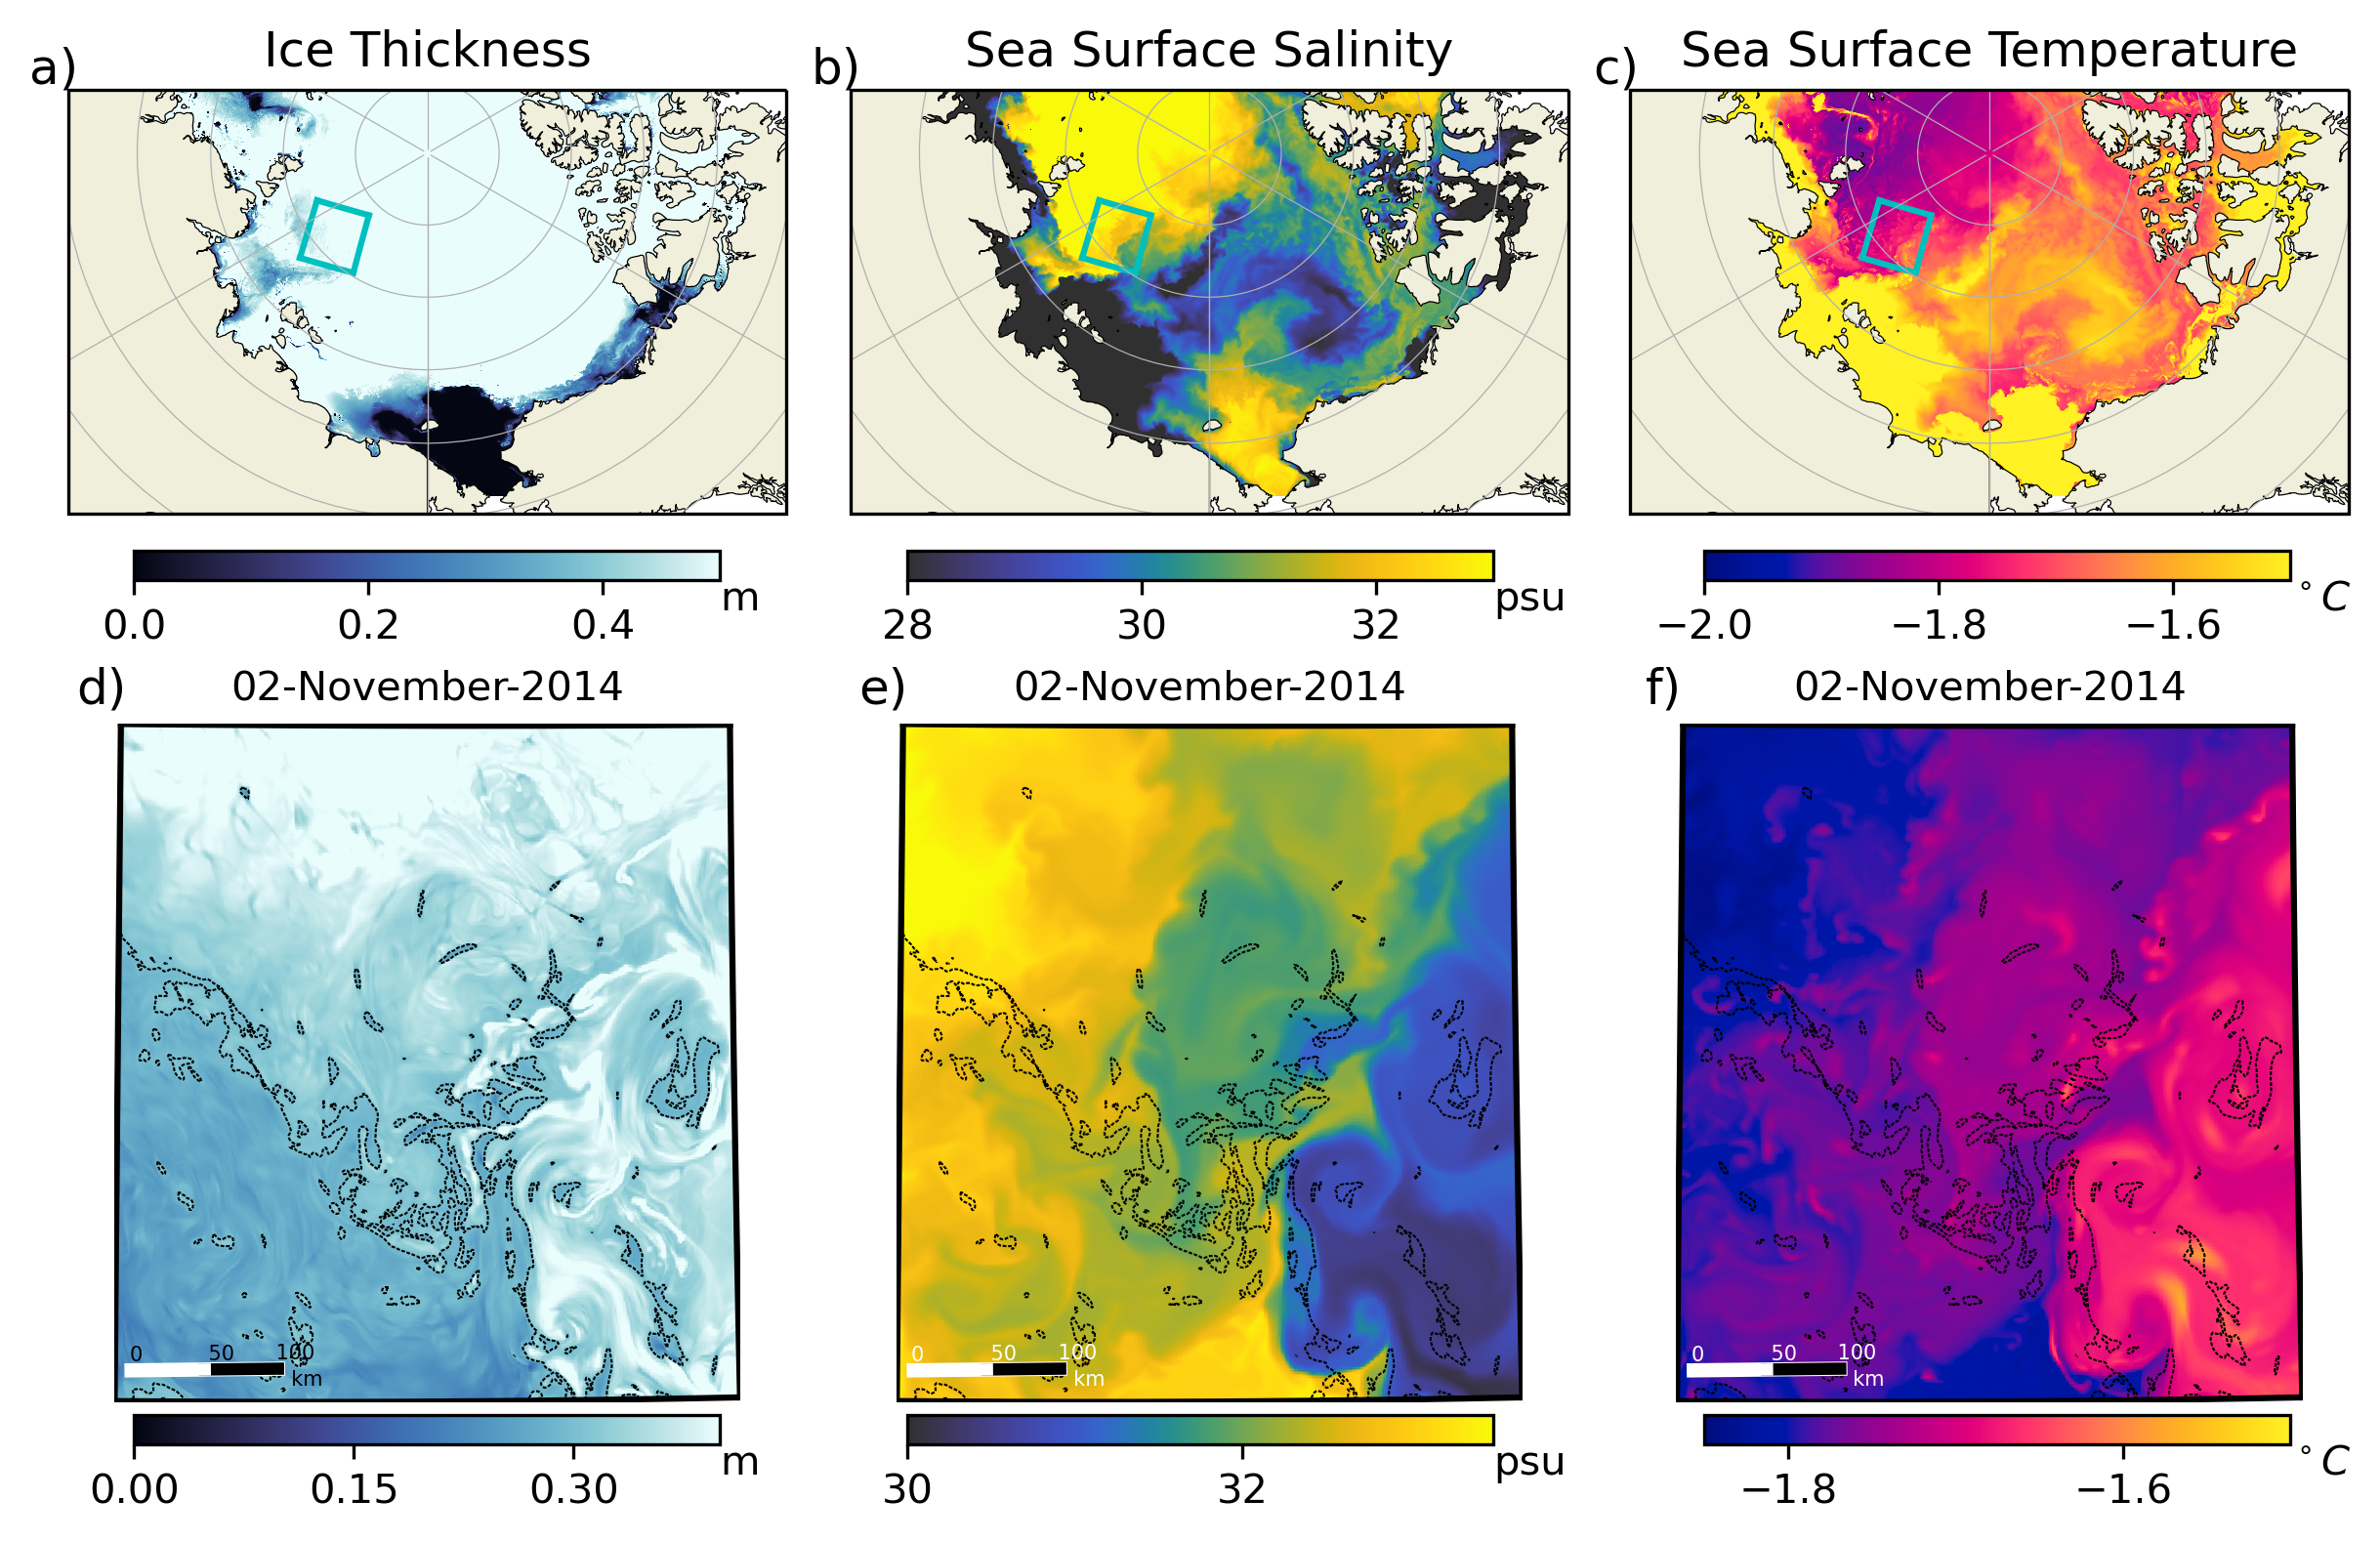

In [17]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create figure
fig = plt.figure(figsize=(8,5),dpi=300, constrained_layout=True)

# Define figure gridspec
gs = GridSpec(4, 6, figure=fig)

ax1 = fig.add_subplot(gs[0:2,0:2],projection=ccrs.NorthPolarStereo(central_longitude=180))
ax2 = fig.add_subplot(gs[0:2,2:4],projection=ccrs.NorthPolarStereo(central_longitude=180))
ax3 = fig.add_subplot(gs[0:2,4:6],projection=ccrs.NorthPolarStereo(central_longitude=180))

nav_lon = ice_conc.nav_lon.isel({'y':slice(y0,y1),'x':slice(x0,x1)})
nav_lat = ice_conc.nav_lat.isel({'y':slice(y0,y1),'x':slice(x0,x1)})

############################################################################################################
################################# Plot PanArtic figures ####################################################
############################################################################################################

icm = iceplot.plot(x='nav_lon',y='nav_lat',ax=ax1,cmap=cm.cm.ice,vmin=0,vmax=0.5, transform=ccrs.PlateCarree(),add_colorbar=False,rasterized=True)

ccm = saltplot.plot(x='nav_lon',y = 'nav_lat',ax=ax2,cmap=ccet.cm.gouldian, vmin=28,vmax=33,  transform=ccrs.PlateCarree(),add_colorbar=False,rasterized=True)

tcm = tempplot.plot(x='nav_lon',y='nav_lat',ax=ax3,cmap=ccet.cm.bmy,vmin=-2,vmax=-1.5, transform=ccrs.PlateCarree(),add_colorbar=False,rasterized=True)

#Add colorbars to each plot

cax = fig.add_axes([0.05, 0.57, 0.25, 0.02])
fig.colorbar(icm, cax=cax, orientation='horizontal')
cax.xaxis.set_major_locator(plt.MaxNLocator(3))

cax.text(0.5,-1,'m')

cax = fig.add_axes([0.38, 0.57, 0.25, 0.02])
fig.colorbar(ccm, cax=cax, orientation='horizontal')
cax.xaxis.set_major_locator(plt.MaxNLocator(3))

cax.text(33,-1,'psu')

cax = fig.add_axes([0.72, 0.57, 0.25, 0.02])
fig.colorbar(tcm, cax=cax, orientation='horizontal')
cax.xaxis.set_major_locator(plt.MaxNLocator(3))

cax.text(-1.5,-1,'$^\circ C$')

# Plot cyan box to show the zoomed area of the Laptov Sea

plot_area(nav_lon,nav_lat,'c',ax1)
plot_area(nav_lon,nav_lat,'c',ax2)
plot_area(nav_lon,nav_lat,'c',ax3)

# Style of figure panels.

ax1.set_title(r"Ice Thickness")
ax1.text(-0.02, 1.05, 'a)',horizontalalignment='center',verticalalignment='center',transform = ax1.transAxes,fontsize=12)
ax2.set_title("Sea Surface Salinity")
ax2.text(-0.02, 1.05, 'b)',horizontalalignment='center',verticalalignment='center',transform = ax2.transAxes,fontsize=12)
ax3.set_title("Sea Surface Temperature")
ax3.text(-0.02, 1.05, 'c)',horizontalalignment='center',verticalalignment='center',transform = ax3.transAxes,fontsize=12)

ax1.add_feature(cartopy.feature.LAND, edgecolor='black',linewidth=0.3,zorder=1)
ax2.add_feature(cartopy.feature.LAND, edgecolor='black',linewidth=0.3,zorder=1)
ax3.add_feature(cartopy.feature.LAND, edgecolor='black',linewidth=0.3,zorder=1)

ax1.set_extent([80, 260, 65, 90], ccrs.PlateCarree())
ax2.set_extent([80, 260, 65, 90], ccrs.PlateCarree())
ax3.set_extent([80, 260, 65, 90], ccrs.PlateCarree())

ax1.gridlines(linewidth=0.3)
ax2.gridlines(linewidth=0.3)
ax3.gridlines(linewidth=0.3)

############################################################################################################
############################ Plot the zoomed area (Ice concentration)#######################################
############################################################################################################

ax1a = fig.add_subplot(gs[2:4,0:2],projection=ccrs.NorthPolarStereo(central_longitude=164))

im_z = iceplot_sdom.isel(time_counter=1).plot(x='nav_lon',y='nav_lat',cmap=cm.cm.ice,vmin=0,vmax=0.4,ax=ax1a,add_colorbar=False,transform=ccrs.PlateCarree(),rasterized=True)
iceplot_sdom.isel(time_counter=1).plot.contour(x='nav_lon',y='nav_lat',ax=ax1a,colors=['k','k'],linestyles=['solid','dashed'],levels=[0.15,0.3], transform=ccrs.PlateCarree(),linewidths=0.5)

strtime = datetime.datetime.strptime(str(iceplot_sdom.isel(time_counter=1).time_counter.values)[0:10], '%Y-%m-%d').strftime('%d-%B-%Y')
ax1a.set_title(strtime,fontsize=10)

ax1a.text(-0.02, 1.05, 'd)',horizontalalignment='center',verticalalignment='center',transform = ax1a.transAxes,fontsize=12)

ax1a.axis('off')

# Plot the box to have a contour in the panel
plot_area(nav_lon,nav_lat,'k',ax1a)

############################################################################################################
################################# Plot the zoomed area (Salinity) ##########################################
############################################################################################################

ax2a = fig.add_subplot(gs[2:4,2:4],projection=ccrs.NorthPolarStereo(central_longitude=164))

sm_z = saltplot_sdom.isel(time_counter=1).plot(x='nav_lon',y='nav_lat',cmap=ccet.cm.gouldian, vmin=30,vmax=33.5 ,ax=ax2a,add_colorbar=False,transform=ccrs.PlateCarree(),rasterized=True)
iceplot_sdom.isel(time_counter=1).plot.contour(x='nav_lon',y='nav_lat',ax=ax2a,colors=['k','k'],linestyles=['solid','dashed'],levels=[0.15,0.3], transform=ccrs.PlateCarree(),linewidths=0.5)

strtime = datetime.datetime.strptime(str(iceplot_sdom.isel(time_counter=1).time_counter.values)[0:10], '%Y-%m-%d').strftime('%d-%B-%Y')
ax2a.set_title(strtime,fontsize=10)

ax2a.text(-0.02, 1.05, 'e)',horizontalalignment='center',verticalalignment='center',transform = ax2a.transAxes,fontsize=12)

ax2a.axis('off')

# Plot the box to have a contour in the panel
plot_area(nav_lon,nav_lat,'k',ax2a)

############################################################################################################
################################ Plot the zoomed area (Temperature) ########################################
############################################################################################################

ax3a = fig.add_subplot(gs[2:4,4:6],projection=ccrs.NorthPolarStereo(central_longitude=164))

tm_z = tempplot_sdom.isel(time_counter=1).plot(x='nav_lon',y='nav_lat',cmap=ccet.cm.bmy,vmin=-1.85,vmax=-1.5,ax=ax3a,add_colorbar=False,transform=ccrs.PlateCarree(),rasterized=True)
iceplot_sdom.isel(time_counter=1).plot.contour(x='nav_lon',y='nav_lat',ax=ax3a,colors=['k','k'],linestyles=['solid','dashed'],levels=[0.15,0.3], transform=ccrs.PlateCarree(),linewidths=0.5)

strtime = datetime.datetime.strptime(str(iceplot_sdom.isel(time_counter=1).time_counter.values)[0:10], '%Y-%m-%d').strftime('%d-%B-%Y')
ax3a.set_title(strtime,fontsize=10)

ax3a.text(-0.02, 1.05, 'f)',horizontalalignment='center',verticalalignment='center',transform = ax3a.transAxes,fontsize=12)

ax3a.axis('off')

# Plot the box to have a contour in the panel
plot_area(nav_lon,nav_lat,'k',ax3a)

# Style of subpanels of Laptov Sea.

scale_bar(ax1a, 100, location=(0.63, 0.13), angle=34, color='k')
scale_bar(ax2a, 100, location=(0.63, 0.13), angle=34, color='w')
scale_bar(ax3a, 100, location=(0.63, 0.13), angle=34, color='w')

cax = fig.add_axes([0.05, -0.02, 0.25, 0.02])
fig.colorbar(im_z, cax=cax, orientation='horizontal')
cax.xaxis.set_major_locator(plt.MaxNLocator(3))

cax.text(0.4,-1,'m')

cax = fig.add_axes([0.38, -0.02, 0.25, 0.02])
fig.colorbar(sm_z, cax=cax, orientation='horizontal')
cax.xaxis.set_major_locator(plt.MaxNLocator(2))

cax.text(33.5,-1,'psu')

cax = fig.add_axes([0.72, -0.02, 0.25, 0.02])
fig.colorbar(tm_z, cax=cax, orientation='horizontal')
cax.xaxis.set_major_locator(plt.MaxNLocator(2))

cax.text(-1.5,-1,'$^\circ C$')

# Save figure
plt.savefig('./figures/Fig_1_ice_conce_and_vorticity_short.pdf',dpi=300,bbox_inches='tight')